In [5]:
from glob import glob
import os.path
import numpy as np
import ujson as json
from matplotlib import pyplot as plt
from datetime import datetime
import bcolz

import pandas as pd
import PIL
from PIL import Image
from numpy.random import random, permutation, randn, normal, uniform, choice, randint
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from matplotlib.pyplot import imread
import tensorflow as tf


import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Activation
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.layers.pooling import *
from keras.preprocessing import image, sequence
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [ ]:
def get_batches(dirname, gen = image.ImageDataGenerator(), shuffle = True, batch_size = 4, class_mode = 'categorical', target_size = (224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size, class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
    
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.samples)])

def plot_log_loss(loss_list, val_loss_list, title = 'log10(model loss)'):
    plt.plot(np.log10(loss_list))
    plt.plot(np.log10(val_loss_list))
    plt.title(title)
    plt.ylabel('log10(loss)')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

def do_clip(arr, mx): 
    return np.clip(arr, (1-mx)/7, mx)

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Data/intel-image-classification/"

In [22]:
batch_size = 64
batches = get_batches(path+'seg_train', batch_size=batch_size)
test_batches = get_batches(path+'seg_test', batch_size=batch_size, shuffle=False)            

Found 14020 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [23]:
print("Training set (images) shape: {shape}".format(shape = batches.image_shape))
print("Training set (images) input: {input}".format(input = batches.classes.size))
print("Training set (images) class: {classes}".format(classes = batches.num_classes))
print("Training set (images) labels: {classes}".format(classes = batches.class_indices))
print("\n")
print("Test set (images) shape: {shape}".format(shape = test_batches.image_shape))
print("Test set (images) input: {input}".format(input = test_batches.classes.size))
print("Test set (images) labels: {classes}".format(classes = test_batches.num_classes))
print("Test set (images) class: {classes}".format(classes = test_batches.class_indices))

Training set (images) shape: (224, 224, 3)
Training set (images) input: 14020
Training set (images) class: 6
Training set (images) labels: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


Test set (images) shape: (224, 224, 3)
Test set (images) input: 3000
Test set (images) labels: 6
Test set (images) class: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


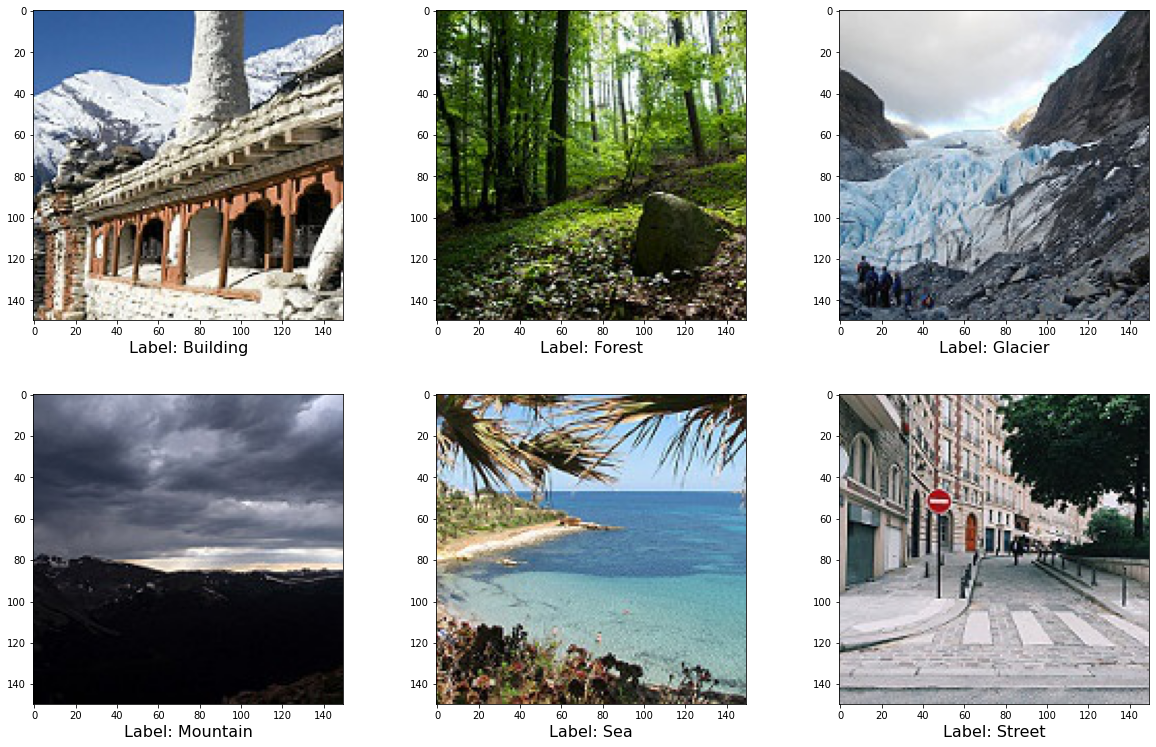

In [24]:
%matplotlib inline
img_path1 = path + 'seg_train/buildings/' + os.listdir(path+'seg_train/buildings')[1]
img1 = np.expand_dims(imread(img_path1),0)
img_path2 = path + 'seg_train/forest/' + os.listdir(path+'seg_train/forest')[1]
img2 = np.expand_dims(imread(img_path2),0)
img_path3 = path + 'seg_train/glacier/' + os.listdir(path+'seg_train/glacier')[1]
img3 = np.expand_dims(imread(img_path3),0)
img_path4 = path + 'seg_train/mountain/' + os.listdir(path+'seg_train/mountain')[1]
img4 = np.expand_dims(imread(img_path4),0)
img_path5 = path + 'seg_train/sea/' + os.listdir(path+'seg_train/sea')[1]
img5 = np.expand_dims(imread(img_path5),0)
img_path6 = path + 'seg_train/street/' + os.listdir(path+'seg_train/street')[1]
img6 = np.expand_dims(imread(img_path6),0)

f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(131)
ax5 = f.add_subplot(132)
ax6 = f.add_subplot(133)

ax1.imshow(img1[0])
ax2.imshow(img2[0])
ax3.imshow(img3[0])
ax4.imshow(img4[0])
ax5.imshow(img5[0])
ax6.imshow(img6[0])

ax1.set_xlabel("Label: Building",fontsize=16)
ax2.set_xlabel("Label: Forest"  ,fontsize=16)
ax3.set_xlabel("Label: Glacier" ,fontsize=16)
ax4.set_xlabel("Label: Mountain",fontsize=16)
ax5.set_xlabel("Label: Sea"     ,fontsize=16)
ax6.set_xlabel("Label: Street"  ,fontsize=16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.4)
plt.show()

In [25]:
#dropout probability
p = 0.4

layers = [
    BatchNormalization(axis=1, input_shape=(224,224,3)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=1),

    #Conv2D(512, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(axis=1),
    #Conv2D(512, (3, 3), activation='relu', padding='same'),
    #BatchNormalization(axis=1),
    #MaxPooling2D(pool_size=(2, 2)),
    Dropout(p/2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(p/2),
    Dense(6, activation='softmax')
]

In [26]:
model = Sequential(layers)
model.compile(Adam(lr=0.001), 
              loss = 'categorical_crossentropy', metrics=['accuracy'])
loss_list = []
val_loss_list = []











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [27]:
#initialize training with a few epochs at a small learning rate
model_fit = model.fit_generator(batches, steps_per_epoch = 50, 
                                validation_data = test_batches, 
                                validation_steps = 10, 
                                epochs = 10)
loss_list += model_fit.history['loss']
val_loss_list += model_fit.history['val_loss']

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
50/50 [==============================] - 862s 17s/step - loss: 1.4042 - acc: 0.5244 - val_loss: 2.1791 - val_acc: 0.5031
Epoch 2/10
50/50 [==============================] - 797s 16s/step - loss: 1.2631 - acc: 0.5573 - val_loss: 1.1836 - val_acc: 0.6953
Epoch 3/10
50/50 [==============================] - 842s 17s/step - loss: 0.9689 - acc: 0.6397 - val_loss: 1.9119 - val_acc: 0.4953
Epoch 4/10
50/50 [==============================] - 853s 17s/step - loss: 0.8532 - acc: 0.6828 - val_loss: 1.8014 - val_acc: 0.3297
Epoch 5/10
50/50 [==============================] - 592s 12s/step - loss: 0.7879 - acc: 0.7087 - val_loss: 0.8099 - val_acc: 0.7753
Epoch 6/10
50/50 [==============================] - 486s 10s/step - loss: 0.7309 - acc: 0.7184 - val_loss: 0.4629 - val_acc: 0.8344
Epoch 7/10
50/50 [==============================] - 487s 10s/step - loss: 0.6529 - acc: 0.7644 - val_loss: 0.543

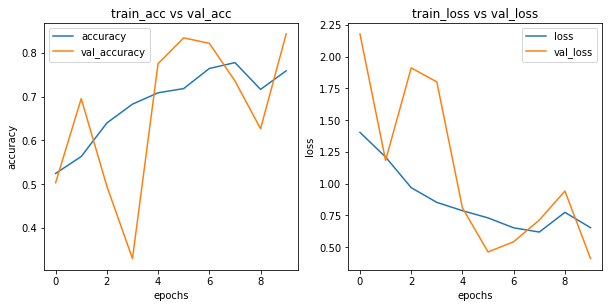

In [33]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(model_fit.history["acc"],label = "accuracy")
plt.plot(model_fit.history['val_acc'], label = "val_accuracy")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(model_fit.history['loss'], label = "loss")
plt.plot(model_fit.history['val_loss'], label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

In [51]:
#get test data and make predictions
pred_batches = get_batches(path+'seg_pred', shuffle = False, batch_size=1, class_mode=None, target_size=(224,224))
pred_data = np.concatenate([pred_batches.next() for i in range(pred_batches.samples)])
pred_filenames = list(map(lambda x: x.split('\\')[-1], pred_batches.filenames))
pred_preds = model.predict(pred_data)

Found 7298 images belonging to 1 classes.


In [ ]:
#clip data to avoid overconfidence
pred_preds_clip = do_clip(pred_preds,0.82)

In [53]:
#create dataframe of predictions and write to csv
pred_preds_df = pd.DataFrame(pred_preds_clip, columns = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])
pred_preds_df['predict'] = pred_preds_df.apply(lambda x:x[(x==x.max())].index.to_series().sample(frac=1).iloc[0], axis=1)
pred_preds_df['image'] = pred_filenames 
pred_preds_df.head(6)

,buildings,forest,glacier,mountain,sea,street,predict,image
0,0.494113,0.026555,0.025714,0.029032,0.025714,0.440220,buildings,seg_pred/10004.jpg
1,0.102837,0.025714,0.138542,0.304091,0.443440,0.025714,sea,seg_pred/10005.jpg
2,0.082269,0.025714,0.025714,0.025714,0.025714,0.820000,street,seg_pred/10012.jpg
3,0.093954,0.025714,0.555533,0.317182,0.025714,0.025714,glacier,seg_pred/10013.jpg
4,0.575821,0.025714,0.033036,0.360258,0.025714,0.025714,buildings,seg_pred/10017.jpg
5,0.025714,0.820000,0.025714,0.025714,0.025714,0.025714,forest,seg_pred/10021.jpg


In [ ]:
pred_preds_df.to_csv('predicted images.csv', index = False, 
                     columns = ["image",'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street',"predict"])

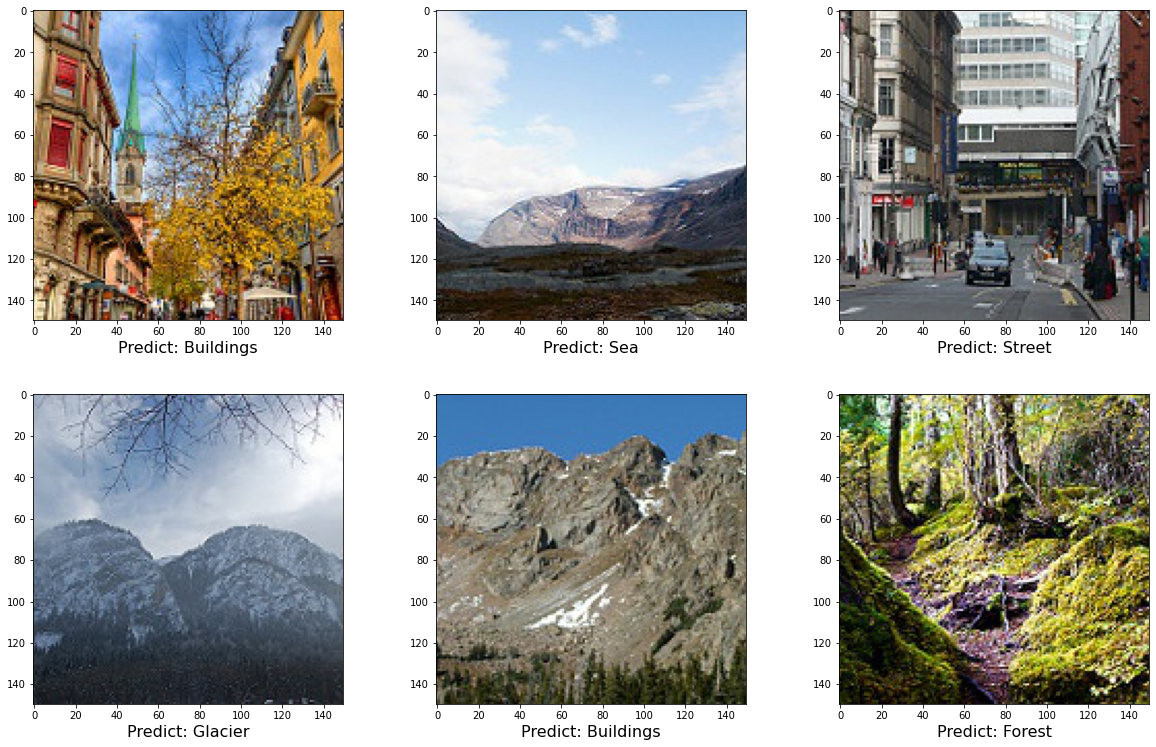

In [54]:
%matplotlib inline
img_path1 = path + 'seg_pred/seg_pred/10004.jpg'
img1 = np.expand_dims(imread(img_path1),0)
img_path2 = path + 'seg_pred/seg_pred/10005.jpg'
img2 = np.expand_dims(imread(img_path2),0)
img_path3 = path + 'seg_pred/seg_pred/10012.jpg'
img3 = np.expand_dims(imread(img_path3),0)
img_path4 = path + 'seg_pred/seg_pred/10013.jpg'
img4 = np.expand_dims(imread(img_path4),0)
img_path5 = path + 'seg_pred/seg_pred/10017.jpg'
img5 = np.expand_dims(imread(img_path5),0)
img_path6 = path + 'seg_pred/seg_pred/10021.jpg'
img6 = np.expand_dims(imread(img_path6),0)


f = plt.figure(figsize=(20,20))

ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(131)
ax5 = f.add_subplot(132)
ax6 = f.add_subplot(133)

ax1.imshow(img1[0])
ax2.imshow(img2[0])
ax3.imshow(img3[0])
ax4.imshow(img4[0])
ax5.imshow(img5[0])
ax6.imshow(img6[0])

ax1.set_xlabel("Predict: Buildings",fontsize=16)
ax2.set_xlabel("Predict: Sea" ,fontsize=16)
ax3.set_xlabel("Predict: Street"   ,fontsize=16)
ax4.set_xlabel("Predict: Glacier" ,fontsize=16)
ax5.set_xlabel("Predict: Buildings"  ,fontsize=16)
ax6.set_xlabel("Predict: Forest"   ,fontsize=16)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=1.4)
plt.show()

In [45]:
pred_preds_df.head(6)

,buildings,forest,glacier,mountain,sea,street,predict,image
0,0.494113,0.026555,0.025714,0.029032,0.025714,0.440220,buildings,seg_pred/10004.jpg
1,0.102837,0.025714,0.138542,0.304091,0.443440,0.025714,sea,seg_pred/10005.jpg
2,0.082269,0.025714,0.025714,0.025714,0.025714,0.820000,street,seg_pred/10012.jpg
3,0.093954,0.025714,0.555533,0.317182,0.025714,0.025714,glacier,seg_pred/10013.jpg
4,0.575821,0.025714,0.033036,0.360258,0.025714,0.025714,buildings,seg_pred/10017.jpg
5,0.025714,0.820000,0.025714,0.025714,0.025714,0.025714,forest,seg_pred/10021.jpg
